In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.probability import FreqDist
import re
from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from subprocess import check_output
print(check_output(["ls", "../content"]).decode("utf8"))

finefoods_training.txt
sample_data



In [ ]:
with open('finefoods_training.txt','r', encoding='latin-1') as f:
    data = f.read()
columns_list=['review/profileName', 'review/score', 'review/summary', 'review/text', 'review/time', 'review/userId', 'review/helpfulness']

ff_df = pd.DataFrame([
    {line.split(': ')[0]:': '.join(line.split(': ')[1:]) 
     for line in record.split('\n') if line.split(': ')[0] in columns_list}
    for record in data.split('\n\n')])

print(ff_df)

       review/userId                            review/profileName  \
0     A3SGXH7AUHU8GW                                    delmartian   
1     A1D87F6ZCVE5NK                                        dll pa   
2      ABXLMWJIXXAIN               Natalia Corres "Natalia Corres"   
3     A395BORC6FGVXV                                          Karl   
4     A1UQRSCLF8GW1T                 Michael D. Bigham "M. Wassir"   
...              ...                                           ...   
1996  A35W3JQYP0M655                       Ambergris "John Thomas"   
1997  A3CLWZGMC7M9Z1                     Hippie2MARS "Hippie2MARS"   
1998  A2V6P1FKRHCVQQ                                    S. Jackson   
1999   AZ9N3928BGQ0E  J. Nachison "long-time SF and history lover"   
2000             NaN                                           NaN   

     review/helpfulness review/score review/time  \
0                   1/1          5.0  1303862400   
1                   0/0          1.0  1346976000   
2  

In [ ]:
ff_df['review/score'] = ff_df['review/score'].astype(float)

In [ ]:
ff_df.dropna(inplace=True)
ff_df[ff_df['review/score'] != 3.0]
ff_df['review/positive'] = np.where(ff_df['review/score'] > 3.0, 1, 0)
ff_df.head()
#ff_df.shape

#If a review is positive, the column will identify as 1, if it is negative, then 0
#All 3.0 scores were eliminated as neutral reviews

,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/positive
0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [ ]:
copy_ff_df = ff_df.drop_duplicates(subset = {'review/userId', 'review/text', 'review/profileName'}, keep = 'first', inplace=False)
copy_ff_df.shape

(1996, 8)

In [ ]:
copy_ff_df = copy_ff_df.rename({'review/text': 'review'}, axis=1)
copy_ff_df.head()

,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review,review/positive
0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


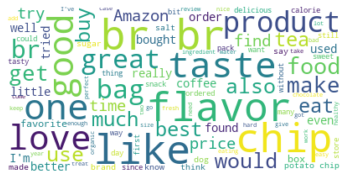

In [ ]:
text = " ".join(review for review in copy_ff_df.review)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [ ]:
def clean(text):
    no_html = bs(text).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
    return re.sub("(\s+)", " ", clean)
 
def tokenize(text):
    clean = bs(text).get_text().lower()
    stopwords_en = stopwords.words("english")
    return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [ ]:
X = copy_ff_df['review']
X_cleaned = X.apply(clean)
X_cleaned = X.apply(tokenize)
X_cleaned

0       [bought, several, vitality, canned, dog, food,...
1       [product, arrived, labeled, jumbo, salted, pea...
2       [confection, around, centuries, light, pillowy...
3       [looking, secret, ingredient, robitussin, beli...
4       [great, taffy, great, price, wide, assortment,...
                              ...                        
1995    [laugh, reviews, said, much, work, add, egg, l...
1996    [read, favorable, reviews, pancake, mix, amazo...
1997    [expecting, great, things, based, reviews, goo...
1998    [love, pancake, mix, bought, first, whole, foo...
1999    [say, wonderful, highlight, weekend, ohhhhhh, ...
Name: review, Length: 1996, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review'], copy_ff_df['review/positive'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (1497,)


In [ ]:
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]

array(['00', 'discovered', 'melts', 'spillage'], dtype=object)

In [ ]:
len(vect.get_feature_names_out())

7259

In [ ]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

0.8316633266533067


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review/userId'], copy_ff_df['review/score'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 A3SGXH7AUHU8GW


X_train shape:  (1497,)


In [ ]:
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]

array(['a103ezcs9h8ww1'], dtype=object)

In [ ]:
len(vect.get_feature_names_out())

1473

In [ ]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [ ]:
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

0.6452905811623246


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review/profileName'], copy_ff_df['review/score'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]
len(vect.get_feature_names_out())
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

X_train first entry: 

 delmartian


X_train shape:  (1497,)
0.6412825651302605


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review/time'], copy_ff_df['review/score'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]
len(vect.get_feature_names_out())
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

X_train first entry: 

 1303862400


X_train shape:  (1497,)
0.6412825651302605


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review/summary'], copy_ff_df['review/score'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]
len(vect.get_feature_names_out())
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

X_train first entry: 

 Good Quality Dog Food


X_train shape:  (1497,)
0.6793587174348698


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copy_ff_df['review'], copy_ff_df['review/score'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)
vect = CountVectorizer().fit(X_train)
vect
vect.get_feature_names_out()[::2000]
len(vect.get_feature_names_out())
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.toarray()
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
score = accuracy_score(y_test, predictions)
print(score)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (1497,)
0.6533066132264529


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
